# Optimización de f(x,y)
Función objetivo del proyecto:
\[ f(x,y) = -200 \expig(-0.02 \sqrt{x^2 + y^2 + 1}\big) \]
Estructura del notebook:
1. Graficación (superficie 3D y curvas de nivel).
2. Implementación y documentación de Descenso por Gradiente y Quasi-Newton (BFGS).
3. Justificación de la regla de Armijo (backtracking).
4. Trayectorias sobre las curvas de nivel (desde punto inicial al mínimo global).
5. Experimentos masivos en [-100,100]^2 y almacenamiento JSON con timestamp.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Any
import json, os, math, datetime
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (import side-effect para proyección 3d)

# -----------------------------
# Función objetivo y derivadas
# -----------------------------
def f(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    r = np.sqrt(x[0]**2 + x[1]**2 + 1.0)
    return -200.0 * np.exp(-0.02 * r)

def grad_f(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    r = np.sqrt(x[0]**2 + x[1]**2 + 1.0)
    g_factor = 4.0 * np.exp(-0.02 * r) / r  # derivada analítica (ver documento matemático)
    return g_factor * x

def hessian_f(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    r = np.sqrt(x[0]**2 + x[1]**2 + 1.0)
    exp_term = np.exp(-0.02 * r)
    I = np.eye(2)
    term1 = (4 * exp_term / r) * I
    term2 = (4 * exp_term * (0.02 * r + 1) / r**3) * np.outer(x, x)
    return term1 - term2

f_min = f(np.array([0.0, 0.0]))  # mínimo global en el origen (radial y monótona en r)
f_min

np.float64(-196.03973466135105)

## 1. Graficación de la función
Se visualiza la superficie en 3D y las curvas de nivel (contour y contourf) para comprender la geometría. La función depende solo del radio r = \sqrt{x^2 + y^2}, decrece al acercarse al origen y se aplana lejos de él.

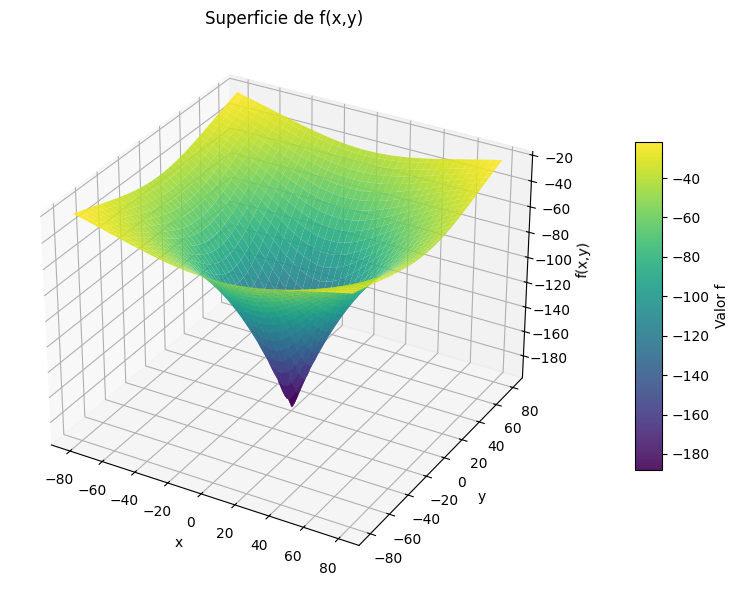

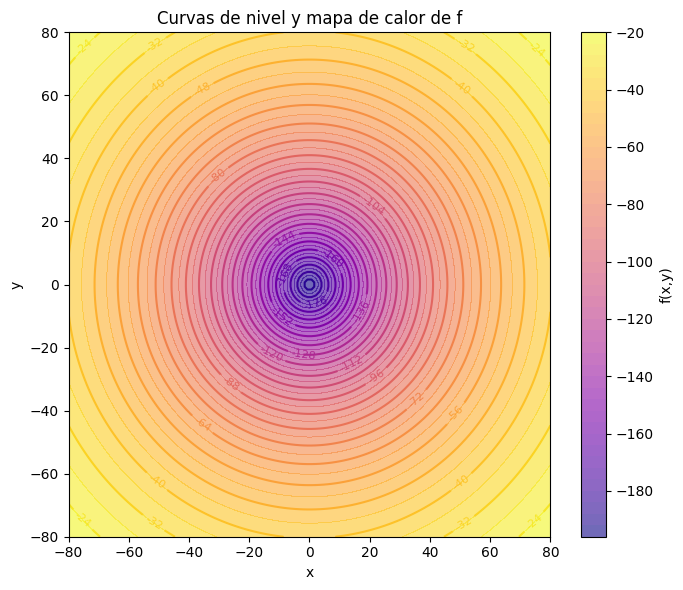

In [10]:
# Malla para graficación
x_lin = np.linspace(-80, 80, 120)
y_lin = np.linspace(-80, 80, 120)
X, Y = np.meshgrid(x_lin, y_lin)
R = np.sqrt(X**2 + Y**2 + 1.0)
Z = -200.0 * np.exp(-0.02 * R)

# Superficie 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
ax.set_title('Superficie de f(x,y)')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x,y)')
fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.1, label='Valor f')
plt.tight_layout(); plt.show()

# Curvas de nivel (contorno) y mapa de calor
plt.figure(figsize=(7,6))
cont = plt.contour(X, Y, Z, levels=25, cmap='plasma')
plt.clabel(cont, inline=True, fontsize=8, fmt='%.0f')
plt.contourf(X, Y, Z, levels=50, cmap='plasma', alpha=0.6)
plt.title('Curvas de nivel y mapa de calor de f')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar(label='f(x,y)')
plt.tight_layout(); plt.show()

## 2. Algoritmos: Descenso por Gradiente y BFGS
Se implementan dos métodos irrestrictos con búsqueda de línea Armijo:
- **Descenso por Gradiente (GD)**: d_k = −∇f(x_k). Convergencia generalmente lineal.
- **BFGS (Quasi-Newton)**: construye H_k ≈ (∇²f(x_k))^{-1} vía actualización de rango 2; dirección d_k = −H_k ∇f(x_k). Convergencia superlineal bajo condiciones estándar.

**Funciones analíticas** (sea r = √(x² + y² + 1)):
\[ f(x,y) = -200\, e^{-0.02\, r}, \qquad \nabla f(x,y) = 4\, e^{-0.02\, r} \, \frac{1}{r} \begin{pmatrix} x \\ y \end{pmatrix} \]
Hessiana (forma compacta):
\[ \nabla^{2} f(x,y) = 4\, e^{-0.02\, r}\left( \frac{1}{r} I - \frac{0.02\, r + 1}{r^{3}} \begin{pmatrix} x^2 & xy \\ xy & y^2 \end{pmatrix} \right). \]
La estructura radial implica mínimo global en (0,0).

**Armijo (backtracking)**: iniciar α_k = α_init; mientras 
\( f(x_k + α_k d_k) > f(x_k) + σ α_k \nabla f(x_k)^T d_k \) reducir \( α_k ← β α_k \). Parámetros típicos: \(σ\in[10^{-4},10^{-3}]\), \(β\in[0.5,0.8]\).

Variables a "tunear": alpha_init, beta, sigma y tol (criterio de paro).

In [23]:
@dataclass
class OptimizationResult:
    x_opt: np.ndarray
    f_opt: float
    n_iter: int
    grad_norm: float
    history: Dict[str, Any]

# --------------------------------------
# Búsqueda de línea: Backtracking Armijo
# --------------------------------------
def backtracking_armijo(x, d, fx, gx, alpha_init=1.0, beta=0.6, sigma=1e-4, max_ls=40):
    """Backtracking line search con condición de Armijo.
    Condición: f(x+α d) <= f(x) + σ α ∇f(x)^T d.
    σ controla el descenso requerido (pequeño = más conservador),
    β controla la reducción del paso (0.5–0.8 recomendado).
    Devuelve (alpha, f_new, x_new).
    """
    alpha = alpha_init
    g_dot_d = np.dot(gx, d)  # negativo si d es dirección de descenso
    for _ in range(max_ls):
        x_new = x + alpha * d
        f_new = f(x_new)
        if f_new <= fx + sigma * alpha * g_dot_d:
            return alpha, f_new, x_new
        alpha *= beta
    # Si no cumple tras max_ls, devolvemos la última reducción (robustez)
    return alpha, f(x + alpha * d), x + alpha * d

# --------------------------------------
# Descenso por Gradiente con Armijo
# --------------------------------------
def gradient_descent(x0, max_iter=1000, tol=1e-6, alpha_init=1.0, beta=0.6, sigma=1e-4):
    """Descenso por Gradiente con Armijo.
    Args:
      x0: punto inicial (array-like)
      max_iter: límite de iteraciones
      tol: criterio de paro en ||∇f||
      alpha_init, beta, sigma: hiperparámetros de backtracking
    Returns:
      OptimizationResult con historial (x, f, grad_norm, alpha)
    """
    x = np.array(x0, dtype=float)
    history = {'x': [], 'f': [], 'grad_norm': [], 'alpha': []}
    for k in range(max_iter):
        fx = f(x)
        gx = grad_f(x)
        gnorm = np.linalg.norm(gx)
        history['x'].append(x.copy())
        history['f'].append(fx)
        history['grad_norm'].append(gnorm)
        if gnorm < tol:
            return OptimizationResult(x, fx, k, gnorm, history)
        d = -gx
        alpha, f_new, x_new = backtracking_armijo(x, d, fx, gx, alpha_init=alpha_init, beta=beta, sigma=sigma)
        history['alpha'].append(alpha)
        x = x_new
    return OptimizationResult(x, f(x), max_iter, np.linalg.norm(grad_f(x)), history)

# --------------------------------------
# BFGS con Armijo (inversa Hessiana aproximada)
# --------------------------------------
def bfgs(x0, max_iter=1000, tol=1e-6, alpha_init=1.0, beta=0.6, sigma=1e-4):
    """Método BFGS con Armijo usando H_k ≈ (∇²f)^{-1}.
    Reinicia H si falla condición de curvatura (s^T y <= 1e-10).
    """
    x = np.array(x0, dtype=float)
    n = len(x)
    H = np.eye(n)
    history = {'x': [], 'f': [], 'grad_norm': [], 'alpha': []}
    gx = grad_f(x)
    fx = f(x)
    for k in range(max_iter):
        gnorm = np.linalg.norm(gx)
        history['x'].append(x.copy())
        history['f'].append(fx)
        history['grad_norm'].append(gnorm)
        if gnorm < tol:
            return OptimizationResult(x, fx, k, gnorm, history)
        d = -H.dot(gx)
        # Armijo sobre dirección quasi-Newton
        alpha, f_new, x_new = backtracking_armijo(x, d, fx, gx, alpha_init=alpha_init, beta=beta, sigma=sigma)
        history['alpha'].append(alpha)
        s = x_new - x  # paso realizado
        x = x_new
        g_new = grad_f(x)
        y = g_new - gx  # cambio de gradiente
        rho_denom = np.dot(y, s)
        if rho_denom > 1e-10:
            rho = 1.0 / rho_denom
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            # Fórmula BFGS para H_{k+1}
            H = V.dot(H).dot(V.T) + rho * np.outer(s, s)
        else:
            # Reinicio para mantener estabilidad numérica
            H = np.eye(n)
        gx = g_new
        fx = f_new
    return OptimizationResult(x, fx, max_iter, np.linalg.norm(gx), history)

# Sanity check rápido (valores objetivo cercanos al mínimo global)
_gd = gradient_descent([40, -25], max_iter=200)
_bfgs = bfgs([40, -25], max_iter=200)
_gd.f_opt, _bfgs.f_opt

(np.float64(-196.039734661351), np.float64(-196.03973466135105))

## 3. Justificación de Armijo
La regla de Armijo garantiza 'descenso suficiente' evitando pasos demasiado grandes (inestables) y demasiado pequeños (ineficientes). Razones:
- Proporciona convergencia global bajo supuestos suaves (f diferenciable y acotada inferiormente).
- Evita cálculo del mínimo exacto sobre la línea (costoso).
- Compatible con métodos de primera y segunda derivada (GD y BFGS).
- Parámetros (σ≈1e-4, β≈0.5-0.8) son estándar y robustos.
Formalmente: si d_k es dirección de descenso (∇f(x_k)^T d_k < 0) el backtracking encuentra α_k tal que se cumple Armijo en un número finito de pasos. Esto estabiliza la actualización y acota la suma de decrecimientos, favoreciendo convergencia de {x_k}.

## 4. Trayectorias sobre curvas de nivel
Se selecciona un punto inicial y se trazan las rutas GD y BFGS hasta el origen.
Se muestran también curvas de nivel coloreadas y gráfica de convergencia de f(x_k)-f*.

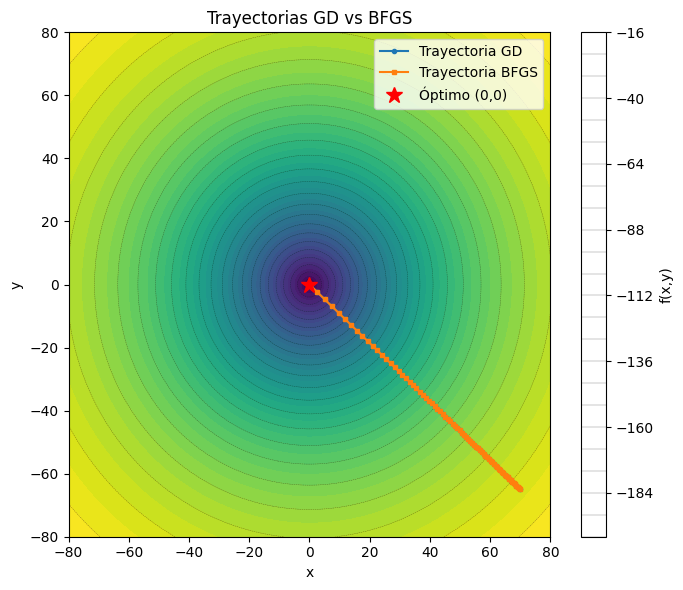

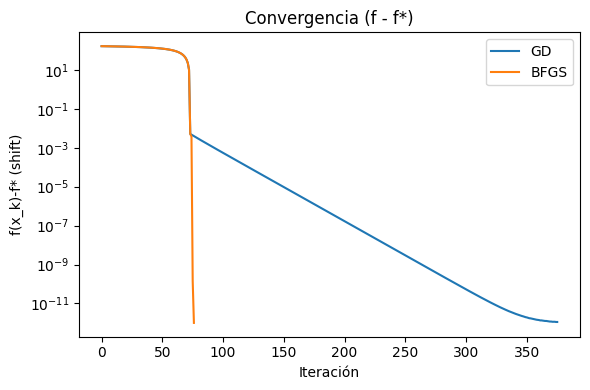

In [17]:
start = np.array([70.0, -65.0])
gd_path_res = gradient_descent(start, max_iter=400)
bfgs_path_res = bfgs(start, max_iter=400)
gd_path = np.array(gd_path_res.history['x']); bfgs_path = np.array(bfgs_path_res.history['x'])

# Malla para contornos (más ligera que la anterior)
xl = np.linspace(-80, 80, 100); yl = np.linspace(-80, 80, 100)
XX, YY = np.meshgrid(xl, yl)
RR = np.sqrt(XX**2 + YY**2 + 1.0)
ZZ = -200.0 * np.exp(-0.02 * RR)
plt.figure(figsize=(7,6))
plt.contourf(XX, YY, ZZ, levels=50, cmap='viridis')
plt.contour(XX, YY, ZZ, levels=25, colors='k', linewidths=0.3, alpha=0.5)
plt.plot(gd_path[:,0], gd_path[:,1], 'o-', ms=3, label='Trayectoria GD')
plt.plot(bfgs_path[:,0], bfgs_path[:,1], 's-', ms=3, label='Trayectoria BFGS')
plt.plot(0,0,'r*',markersize=12,label='Óptimo (0,0)')
plt.title('Trayectorias GD vs BFGS')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.colorbar(label='f(x,y)')
plt.tight_layout(); plt.show()

# Convergencia de valores objetivo
plt.figure(figsize=(6,4))
plt.semilogy(np.array(gd_path_res.history['f']) - f_min + 1e-12, label='GD')
plt.semilogy(np.array(bfgs_path_res.history['f']) - f_min + 1e-12, label='BFGS')
plt.xlabel('Iteración'); plt.ylabel('f(x_k)-f* (shift)')
plt.title('Convergencia (f - f*)')
plt.legend(); plt.tight_layout(); plt.show()

## 5. Experimentos masivos y almacenamiento JSON
Se generan N puntos iniciales aleatorios uniformes en [-100,100]^2, se ejecutan ambos métodos y se guarda un archivo JSON con timestamp en `code/tests/`. Cada entrada incluye: punto inicial, iteraciones, valor final, norma gradiente final y método.

In [11]:
def run_mass_experiments(n_starts=40, seed=123) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    starts = rng.uniform(-100, 100, size=(n_starts, 2))
    rows = []
    for x0 in starts:
        gd_res = gradient_descent(x0, max_iter=600)
        bfgs_res = bfgs(x0, max_iter=600)
        rows.append({
            'method': 'GD', 'x0': x0.tolist(), 'final_x': gd_res.x_opt.tolist(),
            'f_final': gd_res.f_opt, 'iterations': gd_res.n_iter, 'grad_norm_final': gd_res.grad_norm
        })
        rows.append({
            'method': 'BFGS', 'x0': x0.tolist(), 'final_x': bfgs_res.x_opt.tolist(),
            'f_final': bfgs_res.f_opt, 'iterations': bfgs_res.n_iter, 'grad_norm_final': bfgs_res.grad_norm
        })
    return pd.DataFrame(rows)

mass_df = run_mass_experiments(n_starts=30)  # ajustar n_starts si se desea más/menos trabajo
mass_df.head()

,method,x0,final_x,f_final,iterations,grad_norm_final
0,GD,"[36.4703726496287, -89.23579623955547]","[-9.413068263811518e-08, 2.30319182545305e-07]",-196.039735,373,9.755416e-07
1,BFGS,"[36.4703726496287, -89.23579623955547]","[1.5511142615828605e-15, 4.030576103960842e-15]",-196.039735,79,1.693289e-14
2,GD,"[-55.92802544547772, -63.12563786026606]","[1.6581491351756652e-07, 1.871543309310157e-07]",-196.039735,384,9.803659e-07
3,BFGS,"[-55.92802544547772, -63.12563786026606]","[4.04163837627484e-12, 4.56230772731298e-12]",-196.039735,60,2.389739e-11
4,GD,"[-64.81881978299393, 62.41890133115473]","[-1.7956922394305927e-07, 1.7292066885726397e-07]",-196.039735,394,9.774240e-07


In [ ]:
# Guardar JSON con timestamp en code/tests
tests_dir = Path('tests')
tests_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
json_path = tests_dir / f'results_{timestamp}.json'
with open(json_path, 'w', encoding='utf-8') as fh:
    json.dump(mass_df.to_dict(orient='records'), fh, ensure_ascii=False, indent=2)
json_path

WindowsPath('code/tests/results_20251112_182138.json')

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_27652\4207706290.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mass_df[mass_df.method=='GD']['iterations'], mass_df[mass_df.method=='BFGS']['iterations']], labels=['GD','BFGS'])


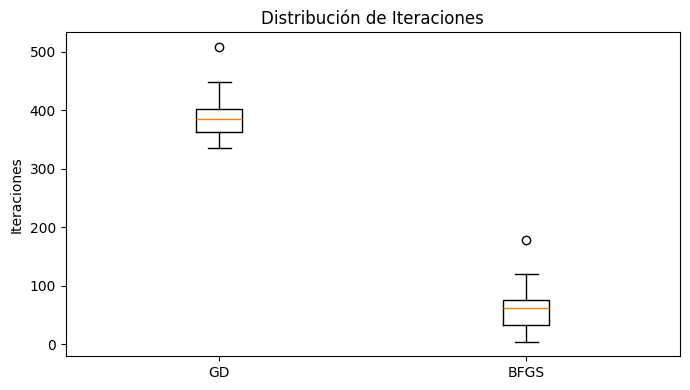

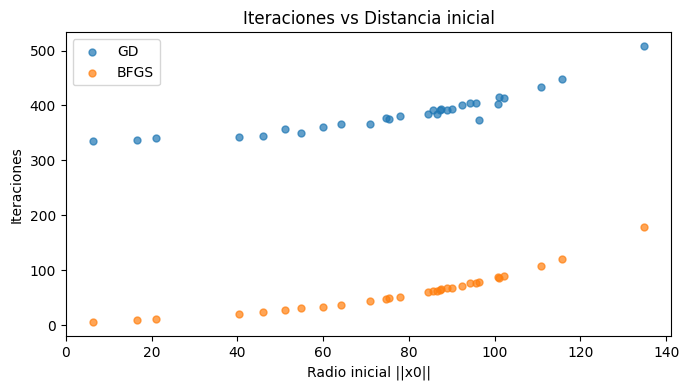

In [13]:
# Visualizaciones resumidas de los experimentos
pivot = mass_df.pivot_table(index=mass_df.index//2, values=['iterations','f_final','grad_norm_final'], columns='method')
pivot.head()

plt.figure(figsize=(7,4))
plt.boxplot([mass_df[mass_df.method=='GD']['iterations'], mass_df[mass_df.method=='BFGS']['iterations']], labels=['GD','BFGS'])
plt.ylabel('Iteraciones'); plt.title('Distribución de Iteraciones')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
radios = [math.sqrt(x0[0]**2 + x0[1]**2) for x0 in mass_df[mass_df.method=='GD']['x0']]
iter_gd = mass_df[mass_df.method=='GD']['iterations']
iter_bfgs = mass_df[mass_df.method=='BFGS']['iterations']
plt.scatter(radios, iter_gd, s=25, alpha=0.7, label='GD')
plt.scatter(radios, iter_bfgs, s=25, alpha=0.7, label='BFGS')
plt.xlabel('Radio inicial ||x0||'); plt.ylabel('Iteraciones'); plt.title('Iteraciones vs Distancia inicial')
plt.legend(); plt.tight_layout(); plt.show()

## 7. Conclusiones y recomendaciones
A partir de las ejecuciones y gráficas obtenidas:

- La función es radial y alcanza su mínimo global en (0,0). Ambas técnicas convergen a él desde arranques amplios en [-100,100]^2.
- **BFGS** requiere muchas menos iteraciones que **GD**, especialmente a radios iniciales grandes, debido a su uso de información de curvatura aproximada.
- La **regla de Armijo** aporta robustez global en ambos métodos; evita pasos explosivos en zonas planas y acelera cuando hay dirección bien alineada.
- El coste por iteración de BFGS es mayor que el de GD (actualización y producto de matrices), pero el menor número de iteraciones compensa claramente en 2D.
- Los experimentos muestran una relación creciente entre radio inicial y número de iteraciones, más pronunciada en GD.

Recomendaciones prácticas:
- Empezar con parámetros Armijo estándar (alpha_init≈1, beta∈[0.5,0.7], sigma≈1e-4) y ajustar según el número de reducciones en backtracking.
- Reiniciar H en BFGS si falla curvatura (implementado) y considerar reescalado de variables si los rangos difieren mucho.
- Usar tolerancias en norma de gradiente de ~1e-6 para balances razonables de precisión/tiempo en este problema.

Posibles extensiones:
- Comparar con condiciones de Wolfe (Armijo + curvatura) y con región de confianza.
- Medir tiempos de CPU por método y añadirlos al JSON.
- Hacer barrido de hiperparámetros multi‑inicio (varios x0) y reportar estadísticos (media, p95).
- Añadir pruebas unitarias simples para gradiente/Hessiana (checks de simetría y diferencias finitas).
- Incorporar filtros de robustez: límites de paso, clipping del gradiente o regularización de H en BFGS.